# Setup

In [88]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import joblib as jb
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from scipy.sparse import csr_matrix
from skopt import forest_minimize
import warnings
warnings.filterwarnings('ignore')

# Functions

In [8]:
def plot_precision_recall_vs_threshold(y_true, y_scores):
    thrh, f1_best, (precisions, recalls, thresholds) = better_threshold(y_true, y_scores, True)
    plt.figure(figsize=(8, 4))
    plt.axis([0, 1.1, 0, 1])
    precision_by_thrs = precisions[np.argmax(thresholds == thrh)]
    recall_by_thrs = recalls[np.argmax(thresholds == thrh)]
    
    plt.plot([thrh, thrh], [0., precision_by_thrs], "r:")
    plt.plot([thrh, thrh], [0., recall_by_thrs], "r:")
    plt.plot([0, thrh], [precision_by_thrs, precision_by_thrs], "r:")
    plt.plot([0, thrh], [recall_by_thrs, recall_by_thrs], "r:")
    plt.plot([thrh], [precision_by_thrs], "ro")        
    plt.plot([thrh], [recall_by_thrs], "ro")   
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")    
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=14)
    plt.xlabel("Threshold")
    plt.ylabel("Value")
    plt.grid(True)
    
def better_threshold(y_true, y_scores, return_precision_recall_threshods=False):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    f1_best = 0
    threshold = 0
    for i in range(len(precisions)):
        if precisions[i] != 0 and recalls[i] != 0:
            f1 = 2*(precisions[i]*recalls[i])/(precisions[i] + recalls[i])
        else:
            f1 = 0
        if f1 > f1_best:
            f1_best = f1
            threshold = thresholds[i]
            
    if return_precision_recall_threshods==False:
        return threshold, f1_best
    
    return threshold, f1_best, (precisions, recalls, thresholds)

In [2]:
df = pd.read_csv("csv\\total_data.csv")
df = df[df["y"].notnull()]
df.head()

,id,title,formats,thumbnails,description,upload_date,uploader,uploader_id,uploader_url,channel_id,...,tbr,protocol,preference,http_headers,release_date,release_year,days_since_upload,thumbnails_links,y,views_per_day
0,JyGGMyR3x5I,Machine Learning: Tutorial prático usando apen...,"[{'asr': 48000, 'filesize': 16323674, 'format_...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",✅ALURA COM 10% DE DESCONTO: https://www.alura....,2019-11-08,Filipe Deschamps,UCU5JicSrEM5A63jkJ2QvGYw,http://www.youtube.com/channel/UCU5JicSrEM5A63...,UCU5JicSrEM5A63jkJ2QvGYw,...,NaN,NaN,NaN,NaN,NaN,NaN,825.0,https://i.ytimg.com/vi_webp/JyGGMyR3x5I/maxres...,0.0,219.296970
1,0PrOA2JK6GQ,Machine Learning Explicado,"[{'asr': 48000, 'filesize': 5203175, 'format_i...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",Machine learning (ou aprendizado de máquina) é...,2021-02-25,Ciência Todo Dia,CienciaTodoDia,http://www.youtube.com/user/CienciaTodoDia,UCn9Erjy00mpnWeLnRqhsA1g,...,NaN,NaN,NaN,NaN,NaN,NaN,350.0,https://i.ytimg.com/vi/0PrOA2JK6GQ/maxresdefau...,0.0,556.602857
2,t5z5lyrb-7s,Introdução ao Machine Learning (ML de Zero a 1...,"[{'asr': 48000, 'filesize': 2603732, 'format_i...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",This video is also available in English: https...,2019-11-13,TensorFlow,UC0rqucBdTuFTjJiefW5t-IQ,http://www.youtube.com/channel/UC0rqucBdTuFTjJ...,UC0rqucBdTuFTjJiefW5t-IQ,...,NaN,NaN,NaN,NaN,NaN,NaN,820.0,https://i.ytimg.com/vi_webp/t5z5lyrb-7s/maxres...,0.0,17.907317
3,5q87K1WaoFI,Computer Scientist Explains Machine Learning i...,"[{'asr': 48000, 'filesize': 9863039, 'format_i...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",WIRED has challenged computer scientist and Hi...,2021-08-18,WIRED,wired,http://www.youtube.com/user/wired,UCftwRNsjfRo08xYE31tkiyw,...,NaN,NaN,NaN,NaN,NaN,NaN,176.0,https://i.ytimg.com/vi/5q87K1WaoFI/maxresdefau...,0.0,5726.215909
4,qDmojpkd8rE,O que é Machine Learning (Aprendizado de Máqui...,"[{'format_id': '139', 'manifest_url': 'https:/...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",Nesse vídeo vamos aprender o que é machine lea...,2019-06-21,Didática Tech,UC0BiVs5EYh57gzGVvhddjsA,http://www.youtube.com/channel/UC0BiVs5EYh57gz...,UC0BiVs5EYh57gzGVvhddjsA,...,NaN,NaN,NaN,NaN,NaN,NaN,965.0,https://i.ytimg.com/vi_webp/qDmojpkd8rE/maxres...,0.0,28.239378


In [3]:
features = ["views_per_day", "days_since_upload", "duration", "view_count"]
df = df.drop_duplicates(subset=['id'])
df[features].isnull().sum()

views_per_day        0
days_since_upload    0
duration             0
view_count           0
dtype: int64

In [4]:
date = "2021-07-25"
mask_train = (df["upload_date"] < date)
mask_val = (df["upload_date"] >= date)

Xtrain, Xval = df[mask_train].drop("y", axis=1), df[mask_val].drop("y", axis=1)
ytrain, yval = df[mask_train].pop("y"), df[mask_val].pop("y")
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((538, 74), (539, 74), (538,), (539,))

In [81]:
title_train = Xtrain["title"]
title_val = Xval["title"]

title_vec = TfidfVectorizer(min_df=2, ngram_range=(1,1))
title_bow_train = title_vec.fit_transform(title_train)
title_bow_val = title_vec.transform(title_val)

Xtrain_wtitle = hstack([Xtrain[features], title_bow_train])
Xval_wtitle = hstack([Xval[features], title_bow_val])

Xtrain_wtitle.shape, Xval_wtitle.shape

((538, 410), (539, 410))

# RF

In [76]:
mdl = RandomForestClassifier(n_estimators=100, random_state=0, min_samples_leaf=2, class_weight="balanced", n_jobs=6)
mdl.fit(Xtrain_wtitle, ytrain)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2, n_jobs=6,
                       random_state=0)

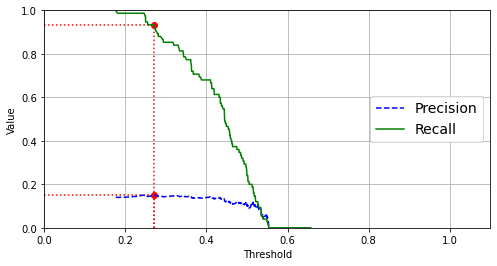

In [77]:
p = mdl.predict_proba(Xval_wtitle)[:, 1]
plot_precision_recall_vs_threshold(yval, p)

In [11]:
better_threshold(yval, p)

(0.31643447380141815, 0.2673992673992674)

f1 -> 0.28571428571428575

f1 -> 0.3333333333333333 - min_df = 1

f1 -> 0.2603036876355748 - min_df = 3

f1 -> 0.2702702702702703 - min_df = 2, ngram_range = (1,2)

f1 -> 0.2780748663101604 - min_df = 2, ngram_range = (1,3)

f1 -> 0.28846153846153844 - min_df = 2, ngram_range = (1,4)

f1 -> 0.3098591549295775 - n_estimators=100

f1 -> 0.2673992673992674 - n_estimators=100, min_sample_leaf=2

In [89]:
mdl_rf = RandomForestClassifier(random_state=0, class_weight="balanced", n_jobs=6)
mdl_rf.fit(Xtrain_wtitle, ytrain)

RandomForestClassifier(class_weight='balanced', n_jobs=6, random_state=0)

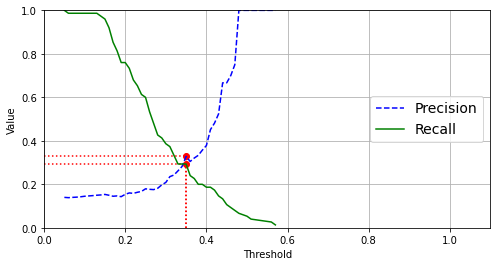

In [90]:
p_rf = mdl_rf.predict_proba(Xval_wtitle)[:, 1]
plot_precision_recall_vs_threshold(yval, p_rf)

# LightGBM

In [12]:
mdl = LGBMClassifier(random_state=0, class_weight="balanced", n_jobs=6)
mdl.fit(Xtrain_wtitle, ytrain)

LGBMClassifier(class_weight='balanced', n_jobs=6, random_state=0)

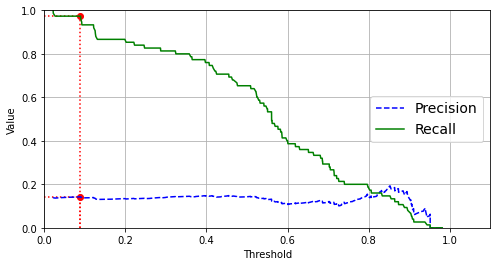

In [13]:
p = mdl.predict_proba(Xval_wtitle)[:, 1]
plot_precision_recall_vs_threshold(yval, p)

In [14]:
better_threshold(yval, p)

(0.08975029405468433, 0.2487223168654174)

# Bayesian Optimization

In [15]:
def tune_lgbm(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    min_df = params[6]
    ngram_range = (1, params[7])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow_train = title_vec.fit_transform(title_train)
    title_bow_val = title_vec.transform(title_val)

    Xtrain_wtitle = hstack([Xtrain[features], title_bow_train])
    Xval_wtitle = hstack([Xval[features], title_bow_val])
    
    mdl = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                        min_child_samples=min_child_samples, subsample=subsample,
                        colsample_bytree=colsample_bytree, bagging_freq=1, n_estimators=n_estimators,
                        random_state=0, class_weight="balanced", n_jobs=6)
    
    mdl.fit(Xtrain_wtitle.todense(), ytrain)
    
    p = mdl.predict_proba(Xval_wtitle.todense())[:,1]
    
    print(better_threshold(yval, p)[1])
    print()
    
    return -better_threshold(yval, p)[1]

space = [(1e-3, 1e-1, 'log-uniform'), # lr
        (1,10), # max_depth
        (1,20), # min_child_samples
        (0.05, 1.), # subsamples
        (0.05, 1.), # colsample_bytree
        (100, 1000), # n_estimators
        (1, 5), # min_df
        (1, 5)] # ngram_range

res = forest_minimize(tune_lgbm, space, n_calls=50, random_state=3, n_random_starts=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.0013849999573349358, 4, 9, 0.5352862249377799, 0.8982996066302721, 814, 4, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.25177304964539005

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4854
Function value obtained: -0.2518
Current minimum: -0.2518
Iteration No: 2 started. Evaluating function at random point.
[0.0012057616701548987, 6, 7, 0.46876935146810467, 0.07838240033463861, 523, 1, 3]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.25429553264604815

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3699
Function value obtained: -0.2543
Current minimum: -0.2543
Iteration No: 3 started. Evaluating function at random point.
[0.0036055752614611095, 7, 3, 0.6113196765455333, 0.0727827882583071, 958, 1, 2]
[LightGBM] [Warning] bagging_freq is set=1, s

0.24695652173913044

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.1318
Function value obtained: -0.2470
Current minimum: -0.2612
Iteration No: 22 started. Searching for the next optimal point.
[0.0015567208064408043, 6, 3, 0.8442395711606477, 0.41580245244427744, 880, 1, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.2546816479400749

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.4671
Function value obtained: -0.2547
Current minimum: -0.2612
Iteration No: 23 started. Searching for the next optimal point.
[0.003766328033817576, 9, 3, 0.7890657737302866, 0.2751402301730269, 807, 1, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.27804878048780485

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.6310
Function value obtained: -0.2780
Current minimum: -0.27

0.26700251889168763

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.8004
Function value obtained: -0.2670
Current minimum: -0.2780
Iteration No: 42 started. Searching for the next optimal point.
[0.0024156817652787616, 9, 7, 0.7750818880546129, 0.2139813737629292, 683, 1, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.2590909090909091

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.8812
Function value obtained: -0.2591
Current minimum: -0.2780
Iteration No: 43 started. Searching for the next optimal point.
[0.0012388717904576873, 6, 1, 0.7825727581666841, 0.9250843400873251, 821, 1, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.2528216704288939

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.4934
Function value obtained: -0.2528
Current minimum: -0.278

0.27383863080684595

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 3.5364
Function value obtained: -0.2738
Current minimum: -0.2780
Iteration No: 62 started. Searching for the next optimal point.
[0.012358381851769164, 10, 1, 0.6792594570450615, 0.7933783294026608, 958, 1, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.2647754137115839

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 15.9020
Function value obtained: -0.2648
Current minimum: -0.2780
Iteration No: 63 started. Searching for the next optimal point.
[0.020006937667957563, 10, 1, 0.608548909639845, 0.30740380016193214, 229, 1, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.26291079812206575

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 3.2270
Function value obtained: -0.2629
Current minimum: -0.2

0.26785714285714285

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.4408
Function value obtained: -0.2679
Current minimum: -0.2835
Iteration No: 82 started. Searching for the next optimal point.
[0.014745081521250997, 9, 3, 0.7061266448229291, 0.2143785508336975, 446, 1, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.2691292875989446

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.2105
Function value obtained: -0.2691
Current minimum: -0.2835
Iteration No: 83 started. Searching for the next optimal point.
[0.021584375022066504, 8, 2, 0.6564189966617375, 0.07970471355951605, 708, 2, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.29230769230769227

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.1801
Function value obtained: -0.2923
Current minimum: -0.292

LGBM -> 0.021584375022066504, 8, 2, 0.6564189966617375, 0.07970471355951605, 708, 2, 4 -> 0.29230769230769227

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


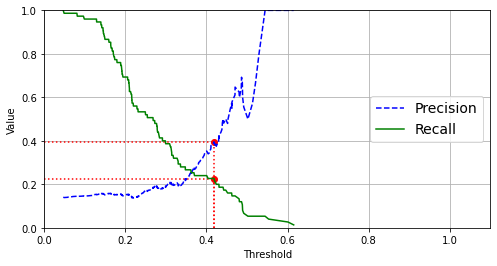

In [91]:
title_vec = TfidfVectorizer(min_df=2, ngram_range=(1,4))
title_bow_train = title_vec.fit_transform(title_train)
title_bow_val = title_vec.transform(title_val)

Xtrain_wtitle = hstack([Xtrain[features], title_bow_train])
Xval_wtitle = hstack([Xval[features], title_bow_val])

mdl_lgbm = LGBMClassifier(learning_rate=0.021584375022066504, num_leaves=2**8, max_depth=8,
                        min_child_samples=2, subsample=0.6564189966617375,
                        colsample_bytree=0.07970471355951605, bagging_freq=1, n_estimators=708,
                        random_state=0, class_weight="balanced", n_jobs=6)

mdl_lgbm.fit(Xtrain_wtitle.todense(), ytrain)
p_lgbm = mdl_lgbm.predict_proba(Xval_wtitle.todense())[:,1]
plot_precision_recall_vs_threshold(yval, p)

# Logistic Regression

In [51]:
Xtrain_wtitle2 = csr_matrix(Xtrain_wtitle.copy())
Xval_wtitle2 = csr_matrix(Xval_wtitle.copy())

# scaler = StandardScaler()
# scaler = MaxAbsScaler()

# Xtrain_wtitle2[:, :len(features)] = scaler.fit_transform(Xtrain_wtitle2[:, :len(features)].todense())
# Xval_wtitle2[:, :len(features)] = scaler.transform(Xval_wtitle2[:, :len(features)].todense())
# Xtrain_wtitle2 = scaler.fit_transform(Xtrain_wtitle2)
# Xval_wtitle2 = scaler.transform(Xval_wtitle2)

lr_pipeline = make_pipeline(MaxAbsScaler(), LogisticRegression(C=0.7, penalty='l2', n_jobs=6, random_state=42))
lr_pipeline.fit(Xtrain_wtitle2, ytrain)

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.7, n_jobs=6, random_state=42))])

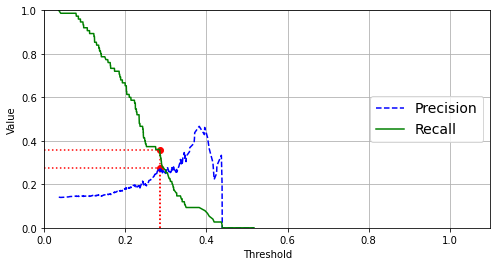

In [52]:
p_lr = lr_pipeline.predict_proba(Xval_wtitle2)[:, 1]
plot_precision_recall_vs_threshold(yval, p)

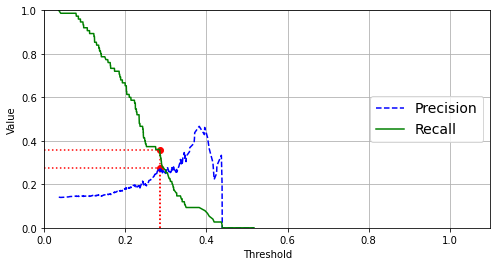

In [42]:
p = mdl.predict_proba(Xval_wtitle2)[:, 1]
plot_precision_recall_vs_threshold(yval, p)

In [43]:
better_threshold(yval, p)

(0.2848724637722357, 0.3121387283236994)

Logistic Regression -> sem tuning, standardscaler -> 0.24711696869851732

Logistic Regression -> sem tuning, MaxAbsScaler -> 0.3121387283236994

Logistic Regression -> C=10, MaxAbsScaler -> 0.29149797570850206

Logistic Regression -> C=0.5, MaxAbsScaler -> 0.29357798165137616

Logistic Regression -> C=0.7, MaxAbsScaler -> 0.3121387283236994

# Ensemble

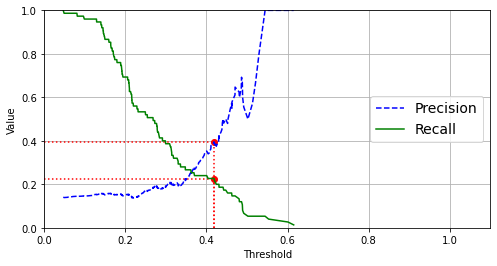

In [85]:
p = (p_lr + p_rf + p_lgbm)/3
plot_precision_recall_vs_threshold(yval, p)

In [86]:
better_threshold(yval, p)

(0.4186513174962843, 0.288135593220339)

In [55]:
pd.DataFrame({"LR": p_lr, "RF": p_rf, "LGBM": p_lgbm}).corr()

,LR,RF,LGBM
LR,1.000000,0.665860,0.579037
RF,0.665860,1.000000,0.682844
LGBM,0.579037,0.682844,1.000000


(0.4246908456032361, 0.3)

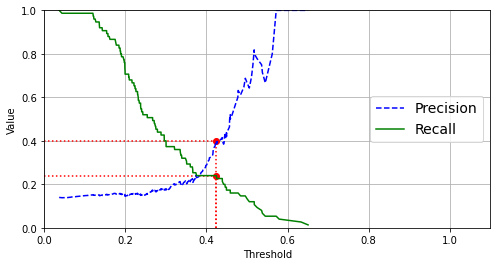

In [84]:
p = 0.7 * p_rf + 0.3 * p_lgbm
plot_precision_recall_vs_threshold(yval, p)
better_threshold(yval, p)

In [87]:
title_train = Xtrain["title"]
title_val = Xval["title"]

title_vec_rf = TfidfVectorizer(min_df=2, ngram_range=(1,1))
title_bow_train = title_vec_rf.fit_transform(title_train)
title_vec_lgbm = TfidfVectorizer(min_df=2, ngram_range=(1,4))
title_bow_train = title_vec_lgbm.fit_transform(title_train)

In [93]:
jb.dump(mdl_lgbm, "models\\lgbm.pkl.z")
jb.dump(mdl_rf, "models\\rf.pkl.z")
jb.dump(lr_pipeline, "models\\lr.pkl.z")
jb.dump(title_vec_rf, "models\\title_vec_rf.pkl.z")
jb.dump(title_vec_lgbm, "models\\title_vec_lgbm.pkl.z")

['models\\title_vec_lgbm.pkl.z']